In [ ]:
pip install medmnist

In [ ]:
pip install opacus

In [ ]:
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import opacus
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import medmnist
from medmnist import INFO, Evaluator

cuda:0


In [ ]:
data_flag = 'pneumoniamnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('dataset description: ' + info['description'])
print('label information: ' + str(info['label']))

dataset description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
label information: {'0': 'normal', '1': 'pneumonia'}


In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [ ]:
def plot_dataset_stats(datasetloader):
  """ visualize the statistics of the dataset """
  num_data_0 = 0
  num_samples = len(datasetloader.dataset)
  for _,labels in datasetloader:
    labels = labels.to(torch.float)
    indx_ = (labels == 0.0).nonzero(as_tuple=True)
    num_data_0 = num_data_0 + len(indx_[0])

  portion = [num_data_0,num_samples-num_data_0]
  plt.pie(portion, shadow=True)
  plt.legend(['Normal: '+str("{:.2f}".format((num_data_0/num_samples)*100))+'%','Pnemounia: '+str("{:.2f}".format((1-(num_data_0/num_samples))*100))+'%'], loc="center")
  plt.show()

In [ ]:
def split_dataset(len_train_dataset):
    """ generates random indices """
    total_size = len_train_dataset
    split1 = 2*total_size // 5
    split2 = split1*2

    #indices = torch.arange(0,total_size)
    indices = np.arange(total_size)
    np.random.seed(500)
    np.random.shuffle(indices)
    np.random.seed(None)
    #shadow model train and test set
    idx_train_1 = indices[:split1]
    idx_train_2 = indices[split1:split2]
    idx_valid = indices[split2:]

    return torch.from_numpy(idx_train_1), torch.from_numpy(idx_train_2),torch.from_numpy(idx_valid)

In [ ]:
def dataset_divide():
  """ divides the dataset into three parts:
      1- training set which will be used for training
      2- a set with equal number of samples as the training set but it will not
       be used for training
      3- validation set
  """
  DataClass = getattr(medmnist, info['python_class'])
  train_dataset = DataClass(split='train', transform=data_transform, download=download)
  valid_dataset = DataClass(split='test', transform=data_transform, download=download)
  combined_data = train_dataset + valid_dataset
  idx_train_1, idx_train_2, idx_valid = split_dataset(len(combined_data))
  train_1 = data_utils.Subset(combined_data, idx_train_1)
  train_2 = data_utils.Subset(combined_data, idx_train_2)
  valid = data_utils.Subset(combined_data, idx_valid)
  return train_1, train_2, valid

In [ ]:
def data_loader(train_1,valid,batch_size,type_alg='non-private'):
  """ generates the dataloader with a given batchsize """
  n = len(train_1)
  if type_alg == 'private':
    train_loader = opacus.data_loader.DPDataLoader(dataset=train_1,sample_rate=batch_size/n)
    valid_loader = torch.utils.data.DataLoader(dataset=valid,batch_size=batch_size)
  else:
    train_loader = torch.utils.data.DataLoader(dataset=train_1,batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(dataset=valid,batch_size=batch_size)
  return train_loader, valid_loader

In [ ]:
class ClassficationModel(nn.Module):
    """ the classification model """
    def __init__(self, input_dim, hidden_dim):
        super(ClassficationModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        #out = self.sigmoid(out)
        return out

In [ ]:
class TrainingClassifier(nn.Module):
  """ training the classifier non-privately """
  def __init__(self,model,learning_rate,num_epochs,batch_size,train_dataset,valid_dataset):
    super(TrainingClassifier, self).__init__()
    self.model = model
    self.criterion = nn.BCEWithLogitsLoss()
    self.learning_rate = learning_rate
    self.num_epochs = int(num_epochs)
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=learning_rate)
    self.loss_train = []
    self.acc_train = []
    self.acc_valid = []
    self.snapshot_iter = []
    self.train_loader,self.valid_loader=data_loader(train_dataset,valid_dataset,batch_size)




  def training_loop(self):
    iter = 0
    for epoch in range(self.num_epochs):
        for i, (images, labels) in enumerate(self.train_loader):
          images = images.view(-1, 28*28)
          self.optimizer.zero_grad()
          labels = labels.to(torch.float)
          outputs = self.model.forward(images)
          loss = self.criterion(outputs, labels)
          self.loss_train.append(loss.item())
          loss.backward()
          self.optimizer.step()
          if iter % 10 == 0:
            self.snapshot_iter.append(iter)
            self.acc_train.append(self.accuracy_model('train'))
            self.acc_valid.append(self.accuracy_model('valid'))
            #self.precision_recall('valid')
            if iter % 50 == 0:
              print('Iteration: {}. Loss Training: {:.3f}. Accuracy Training: {:.2f}. Accuracy Validation: {:.2f}'.format(iter, loss.item(), self.acc_train[-1], self.acc_valid[-1]))

          iter += 1

  def accuracy_model(self,train_or_valid):
    if train_or_valid == 'train':
      dataset_loader = self.train_loader
    else:
      dataset_loader = self.valid_loader

    correct = 0
    total = 0
    for images, labels in dataset_loader:
        images = images.view(-1, 28*28)
        labels = labels.to(torch.float)
        outputs = nn.Sigmoid()(self.model(images))
        predicted = torch.round(outputs).data
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * correct / total

  def precision_recall(self,train_or_valid):
    if train_or_valid == 'train':
      dataset_loader = self.train_loader
    else:
      dataset_loader = self.valid_loader

    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0
    for images, labels in dataset_loader:
      images = images.view(-1, 28*28)
      labels = torch.flatten(labels.to(torch.float))
      indx_ = (labels == 1).nonzero(as_tuple=True)[0].tolist()
      outputs = nn.Sigmoid()(self.model(images))
      predicted = torch.round(outputs).data
      predicted_flat = torch.flatten(predicted)
      tp = torch.mul(labels,predicted_flat).sum().item()
      true_positive += tp
      false_positive += (predicted.sum().item() - tp)
      false_negative += len(indx_) - predicted[indx_].sum().item()


    print('Precision: {}. Recall: {}'.format(100*true_positive/(true_positive+false_positive),100*true_positive/(true_positive+false_negative)))


  def plot_learning_curve(self):
    num_iter = range(len(self.loss_train))
    plt.figure(1)
    plt.plot(num_iter, self.loss_train)
    plt.title('training loss')
    plt.xlabel('iteration')
    plt.ylabel('cross entropy loss')
    plt.show()

    plt.figure(2)
    plt.plot(self.snapshot_iter,  self.acc_valid, label = 'validation')
    plt.plot(self.snapshot_iter,  self.acc_train, label = 'training')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


  def compare_logits(self):
    for dataset_loader in [self.train_loader,self.valid_loader]:
      for label_target in [0,1]:
        num_data = 0
        prob_pred_1 = []
        for images, labels in dataset_loader:
          images = images.view(-1, 28*28)
          labels = labels.to(torch.float)
          indx_ = (labels == label_target).nonzero(as_tuple=True)
          num_data = num_data + len(indx_[0])
          outputs = nn.Sigmoid()(self.model(images[indx_[0]]))
          predicted = outputs.data
          prob_pred_1 = prob_pred_1 + torch.flatten(predicted).tolist()


        probs_plot = [1 - sum(prob_pred_1)/num_data, sum(prob_pred_1)/num_data]
        print(probs_plot)
        plt.figure()
        plt.bar(['Class 0: Normal','Class 1: Pneumonia'], probs_plot ,width = 0.3)
        plt.xlabel("predicted label")
        plt.ylabel("Confidence")
        if dataset_loader == self.train_loader:
          plt.title('training data'+'--'+'true class: '+str(label_target))
        else:
          plt.title('validation data'+'--'+'true class: '+str(label_target))
        plt.show()

In [ ]:
class TrainingPrivateClassifier(nn.Module):
  """ training the classifier privately """
  def __init__(self, model, learning_rate, num_epochs, epsilon, batch_size, max_grad_norm,train_dataset,valid_dataset):
    super(TrainingPrivateClassifier, self).__init__()
    self.model = model
    self.criterion = nn.BCEWithLogitsLoss()
    self.learning_rate = learning_rate
    self.num_epochs = int(num_epochs)
    #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
    self.loss_train = []
    self.acc_train = []
    self.acc_valid = []
    self.batch_size = batch_size
    self.snapshot_iter = []
    self.train_loader,self.valid_loader=data_loader(train_dataset,valid_dataset,self.batch_size,type_alg='private')
    self.epsilon = epsilon
    self.sampling_rate = batch_size/len(train_dataset)
    self.max_grad_norm = max_grad_norm
    self.noise_multiplier = opacus.accountants.utils.get_noise_multiplier(target_epsilon=self.epsilon, target_delta=1/len(train_dataset),sample_rate=self.sampling_rate,epochs=self.num_epochs)
    print('noise multiplier is ', self.noise_multiplier)
    self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=len(train_dataset)//batch_size * num_epochs)


  def dp_grads(self,batch_data):
    clipped_noisy_grads = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}
    for xi,yi in batch_data:
      pred = self.model.forward(xi)
      lossi = self.criterion(pred,yi)
      lossi.backward(retain_graph=True)
      torch.nn.utils.clip_grad_norm_(self.model.parameters(),self.max_grad_norm)
      for name, param in self.model.named_parameters():
        clipped_noisy_grads[name] += param.grad
      self.model.zero_grad()


    for name, param in self.model.named_parameters():
      clipped_noisy_grads[name] += torch.normal(mean=0.0, std=self.noise_multiplier * self.max_grad_norm, size=param.size())
      clipped_noisy_grads[name] /= self.batch_size

    return clipped_noisy_grads


  def training_loop(self):
    iter = 0
    for epoch in range(self.num_epochs):
        for i, (images, labels) in enumerate(self.train_loader):
          self.optimizer.zero_grad()
          images = images.view(-1, 28*28)
          labels = labels.to(torch.float)
          outputs = self.model.forward(images)
          loss = self.criterion(outputs, labels)
          self.loss_train.append(loss.item())
          batch_data = zip(images,labels)
          clipped_noisy_grads = self.dp_grads(batch_data)
          for name, param in self.model.named_parameters():
            param.grad = clipped_noisy_grads[name]
          self.optimizer.step()
          self.scheduler.step()
          #print(list(self.model.parameters())[0].grad)
          if iter % 10 == 0:
            self.snapshot_iter.append(iter)
            self.acc_train.append(self.accuracy_model('train'))
            self.acc_valid.append(self.accuracy_model('valid'))
            #self.precision_recall('valid')
            if iter % 50 == 0:
              print('Iteration: {}. Loss Training: {:.3f}. Accuracy Training: {:.2f}. Accuracy Validation: {:.2f}'.format(iter, loss.item(), self.acc_train[-1], self.acc_valid[-1]))

          iter += 1

  def accuracy_model(self,train_or_valid):
    if train_or_valid == 'train':
      dataset_loader = self.train_loader
    else:
      dataset_loader = self.valid_loader

    correct = 0
    total = 0
    for images, labels in dataset_loader:
        images = images.view(-1, 28*28)
        labels = labels.to(torch.float)
        outputs = nn.Sigmoid()(self.model(images))
        predicted = torch.round(outputs).data
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * correct / total

  def precision_recall(self,train_or_valid):
    if train_or_valid == 'train':
      dataset_loader = self.train_loader
    else:
      dataset_loader = self.valid_loader

    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0
    for images, labels in dataset_loader:
      images = images.view(-1, 28*28)
      labels = torch.flatten(labels.to(torch.float))
      indx_ = (labels == 1).nonzero(as_tuple=True)[0].tolist()
      outputs = nn.Sigmoid()(self.model(images))
      predicted = torch.round(outputs).data
      predicted_flat = torch.flatten(predicted)
      tp = torch.mul(labels,predicted_flat).sum().item()
      true_positive += tp
      false_positive += (predicted.sum().item() - tp)
      false_negative += len(indx_) - predicted[indx_].sum().item()


    print('Precision: {}. Recall: {}'.format(100*true_positive/(true_positive+false_positive),100*true_positive/(true_positive+false_negative)))


  def plot_learning_curve(self):
    num_iter = range(len(self.loss_train))
    plt.figure(1)
    plt.plot(num_iter, self.loss_train)
    plt.title('training loss')
    plt.xlabel('iteration')
    plt.ylabel('cross entropy loss')
    plt.show()

    plt.figure(2)
    plt.plot(self.snapshot_iter,  self.acc_valid, label = 'validation')
    plt.plot(self.snapshot_iter,  self.acc_train, label = 'training')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

  def compare_logits(self):
    for dataset_loader in [self.train_loader,self.valid_loader]:
      for label_target in [0,1]:
        num_data = 0
        prob_pred_1 = []
        for images, labels in dataset_loader:
          images = images.view(-1, 28*28)
          labels = labels.to(torch.float)
          indx_ = (labels == label_target).nonzero(as_tuple=True)
          num_data = num_data + len(indx_[0])
          outputs = nn.Sigmoid()(self.model(images[indx_[0]]))
          predicted = outputs.data
          prob_pred_1 = prob_pred_1 + torch.flatten(predicted).tolist()


        probs_plot = [1 - sum(prob_pred_1)/num_data, sum(prob_pred_1)/num_data]
        print(probs_plot)
        plt.figure()
        plt.bar(['Class 0: Normal','Class 1: Pneumonia'], probs_plot ,width = 0.3)
        plt.xlabel("predicted label")
        plt.ylabel("Confidence")
        if dataset_loader == self.train_loader:
          plt.title('training data'+'--'+'true class: '+str(label_target))
        else:
          plt.title('validation data'+'--'+'true class: '+str(label_target))
        plt.show()

In [ ]:
def prepare_attack_dataloader(model,dataset_in,dataset_out,label_target):
    """ a function that creates a dataset for comparing the output logits of
        the training set and outside samples.
         """
    attackX = []
    attackY = []
    dataset_loader_in = torch.utils.data.DataLoader(dataset=dataset_in,batch_size=200)
    dataset_loader_out = torch.utils.data.DataLoader(dataset=dataset_out,batch_size=200)
    for dataset_loader in [dataset_loader_in,dataset_loader_out]:
      for images, labels in dataset_loader:
          images = images.view(-1, 28*28)
          labels = labels.to(torch.float)
          indx_ = (labels == label_target).nonzero(as_tuple=True)
          outputs = nn.Sigmoid()(model(images[indx_[0]]))
          attackX = attackX + torch.flatten(outputs.data).tolist()
          if dataset_loader == dataset_loader_in:
            attackY = attackY + [1.0]*(outputs.size(0)) # the label for "in" samples is 1
          else:
            attackY = attackY + [0.0]*(outputs.size(0))# the label for "out" samples is 0
    batch_size_attack = 200
    xt = torch.tensor(data=attackX, dtype=torch.float32)
    xt = torch.reshape(xt, (xt.size(0), 1))
    yt = torch.tensor(data = attackY, dtype=torch.float32)
    yt = torch.reshape(yt, (yt.size(0), 1))
    my_dataset = TensorDataset(xt,yt)
    my_dataloader = torch.utils.data.DataLoader(dataset = my_dataset, batch_size=batch_size_attack)
    return my_dataloader

In [ ]:
# def scatter_in_out_pred(datasetlodaer,label_aux):
#   """ Plot CDF of logits """
#   pred_vec_in = []
#   pred_vec_out = []
#   for pred, labels in datasetlodaer:
#       indx_in = (torch.flatten(labels) == 1).nonzero(as_tuple=True)
#       indx_out = (torch.flatten(labels) == 0).nonzero(as_tuple=True)
#       if list(indx_in[0].size())[0]>0:
#         pred_vec_in += torch.flatten(pred[indx_in[0]]).tolist()
#       if list(indx_out[0].size())[0]>0:
#         pred_vec_out += torch.flatten(pred[indx_out[0]]).tolist()
#   x = -np.log(pred_vec_in)
#   plt.hist(x, bins=200,color='g',label='inside',cumulative=True, density=True)
#   plt.title(label_aux)
#   plt.legend()
#   plt.show()
#   x = -np.log(pred_vec_out)
#   plt.hist(x, bins=200,color='r',label='out',cumulative=True, density=True)
#   plt.title(label_aux)
#   plt.legend()
#   plt.show()




In [ ]:
def scatter_in_out_pred(datasetlodaer,label_aux):
  """ Plot CDF of logits """
  pred_vec_in = []
  pred_vec_out = []
  for pred, labels in datasetlodaer:
      indx_in = (torch.flatten(labels) == 1).nonzero(as_tuple=True)
      indx_out = (torch.flatten(labels) == 0).nonzero(as_tuple=True)
      if list(indx_in[0].size())[0]>0:
        pred_vec_in += torch.flatten(pred[indx_in[0]]).tolist()
      if list(indx_out[0].size())[0]>0:
        pred_vec_out += torch.flatten(pred[indx_out[0]]).tolist()
  x = -np.log(pred_vec_in)
  plt.hist(x, bins=200,color='b',label='inside', alpha=1, cumulative=True, density=True)
  x = -np.log(pred_vec_out)
  plt.hist(x, bins=200,color='r',label='out', alpha=0.1,cumulative=True, density=True)
  plt.title(label_aux)
  plt.legend()
  plt.show()


Loading Dataset



Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
statistics for training set


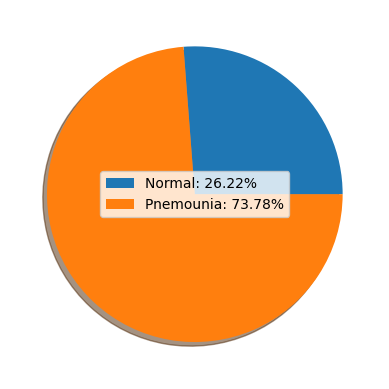

statistics for validation set


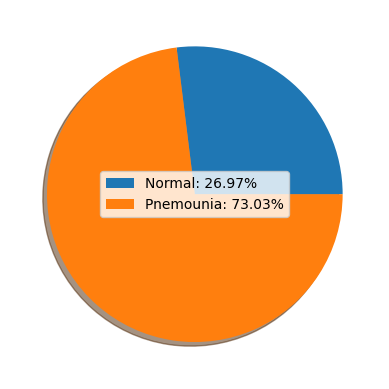

In [ ]:
train_dataset, out_dataset, valid_dataset = dataset_divide()
print('statistics for training set')
plot_dataset_stats(torch.utils.data.DataLoader(dataset=train_dataset))
print('statistics for validation set')
plot_dataset_stats(torch.utils.data.DataLoader(dataset=valid_dataset))

In [ ]:
input_dim = 28*28
hidden_dim = 500
# parameters for non-private classifier
lr_non_private = 1e-3
epochs_non_private = 55
batchsize_non_private = 100


# parameters for private classifier
lr_private = 2e-1
epochs_private = 30
batchsize_private = 200
max_grad_norm = 4
epsilon = 0.5

In [ ]:
model_np = ClassficationModel(input_dim,hidden_dim)
model_p = ClassficationModel(input_dim,hidden_dim)

Training model non-privately

Iteration: 0. Loss Training: 0.788. Accuracy Training: 73.78. Accuracy Validation: 73.03
Iteration: 50. Loss Training: 0.229. Accuracy Training: 92.17. Accuracy Validation: 89.33
Iteration: 100. Loss Training: 0.193. Accuracy Training: 94.28. Accuracy Validation: 92.42
Iteration: 150. Loss Training: 0.134. Accuracy Training: 95.54. Accuracy Validation: 93.07
Iteration: 200. Loss Training: 0.093. Accuracy Training: 96.06. Accuracy Validation: 93.63
Iteration: 250. Loss Training: 0.093. Accuracy Training: 96.76. Accuracy Validation: 93.54
Iteration: 300. Loss Training: 0.071. Accuracy Training: 96.86. Accuracy Validation: 93.63
Iteration: 350. Loss Training: 0.052. Accuracy Training: 97.56. Accuracy Validation: 93.91
Iteration: 400. Loss Training: 0.044. Accuracy Training: 97.42. Accuracy Validation: 93.82
Iteration: 450. Loss Training: 0.069. Accuracy Training: 97.61. Accuracy Validation: 93.54
Iteration: 500. Loss Training: 0.103. Accuracy Training: 98.08. Accuracy Validation: 94.01
It

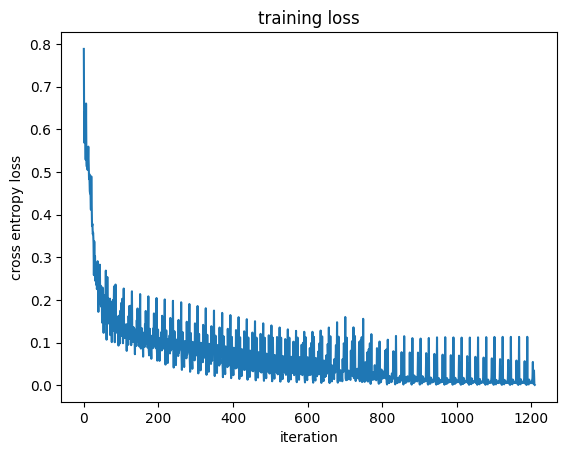

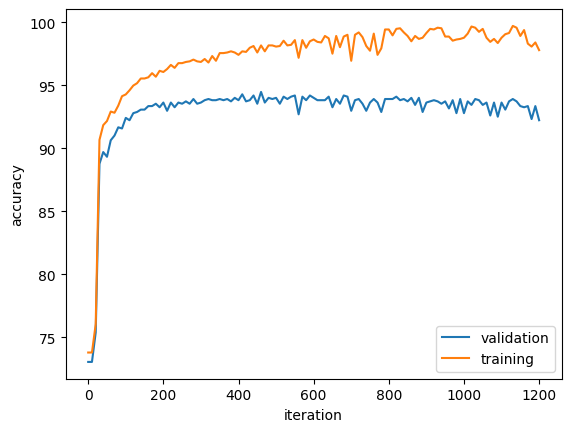

In [ ]:
training_np = TrainingClassifier(model=model_np,
                                  learning_rate=lr_non_private,
                                  num_epochs=epochs_non_private,
                                  batch_size=batchsize_non_private,
                                  train_dataset=train_dataset,
                                  valid_dataset=valid_dataset)
training_np.training_loop()
training_np.plot_learning_curve()

[0.9581161940328012, 0.04188380596719877]


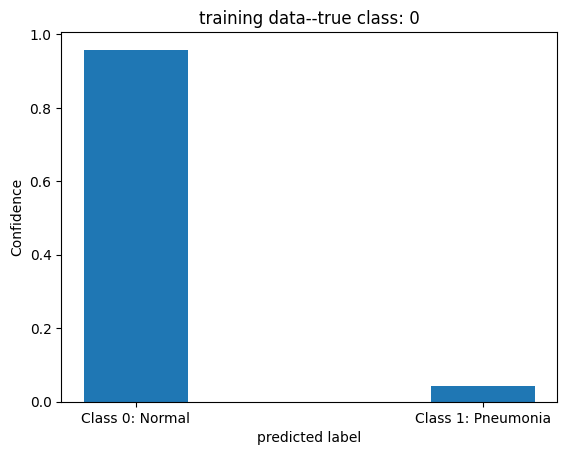

[0.0010105677266372126, 0.9989894322733628]


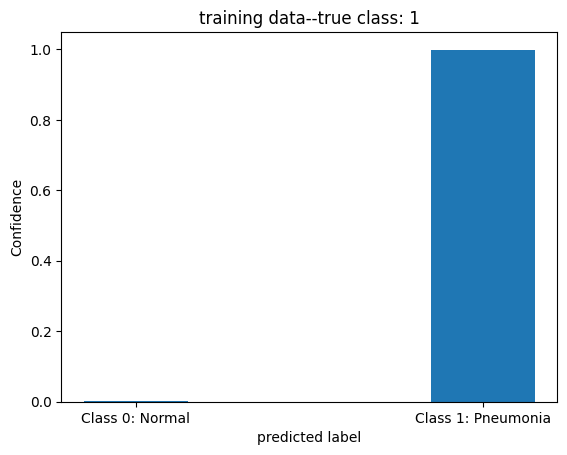

[0.842630308333776, 0.15736969166622405]


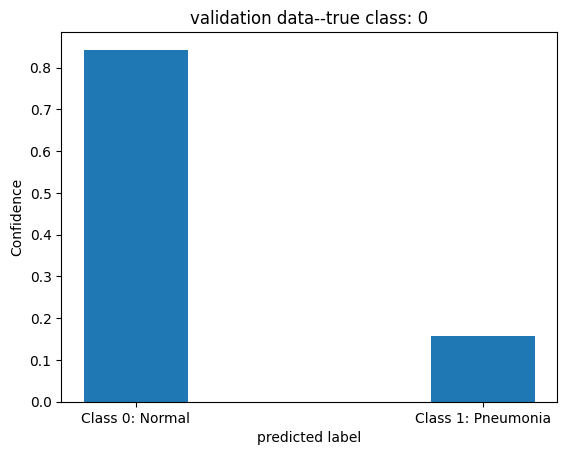

[0.031736453341423276, 0.9682635466585767]


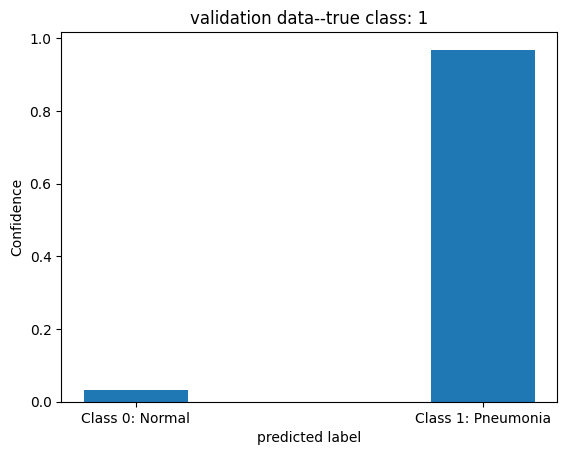

In [ ]:
training_np.compare_logits()

Training model with differential privacy

noise multiplier is  9.6875
Iteration: 0. Loss Training: 0.698. Accuracy Training: 75.73. Accuracy Validation: 73.03
Iteration: 50. Loss Training: 0.449. Accuracy Training: 82.83. Accuracy Validation: 82.87
Iteration: 100. Loss Training: 0.277. Accuracy Training: 86.97. Accuracy Validation: 85.77
Iteration: 150. Loss Training: 0.291. Accuracy Training: 87.52. Accuracy Validation: 85.96
Iteration: 200. Loss Training: 0.305. Accuracy Training: 90.70. Accuracy Validation: 87.83
Iteration: 250. Loss Training: 0.236. Accuracy Training: 91.12. Accuracy Validation: 88.20


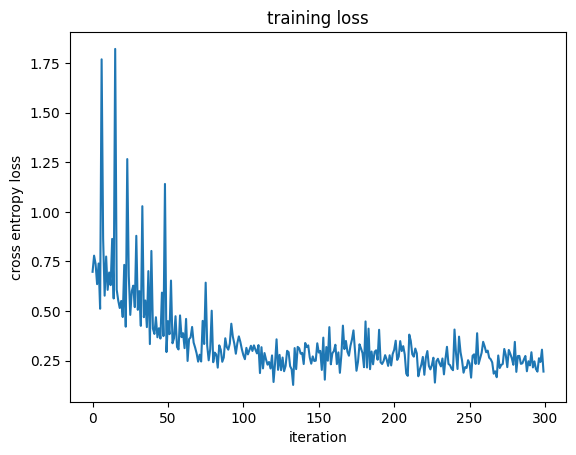

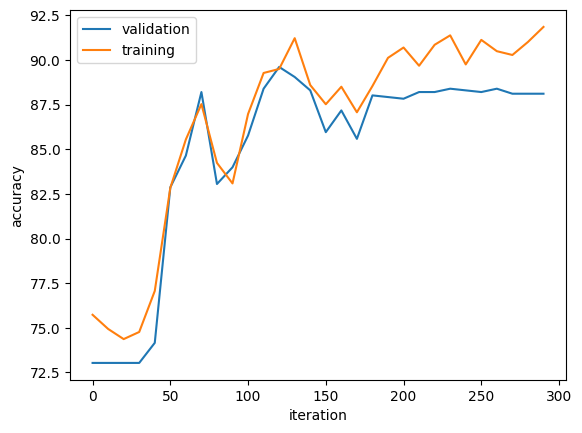

In [ ]:
training_p = TrainingPrivateClassifier(model=model_p,learning_rate=lr_private,
                                  num_epochs=epochs_private,
                                  epsilon=epsilon,
                                  batch_size=batchsize_private,
                                  max_grad_norm=max_grad_norm,
                                  train_dataset=train_dataset,
                                  valid_dataset=valid_dataset)


training_p.training_loop()
training_p.plot_learning_curve()

[0.7568901095335312, 0.24310989046646886]


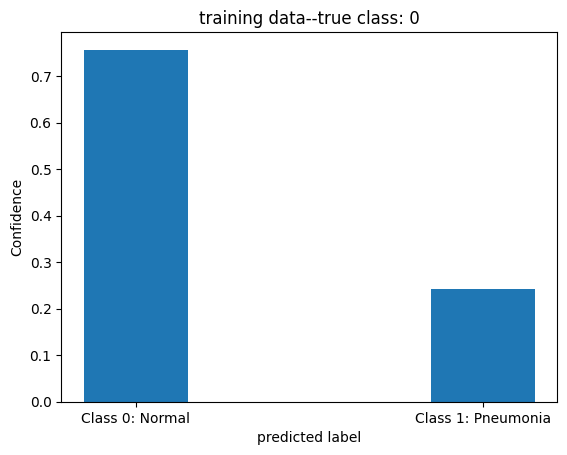

[0.07513281988790477, 0.9248671801120952]


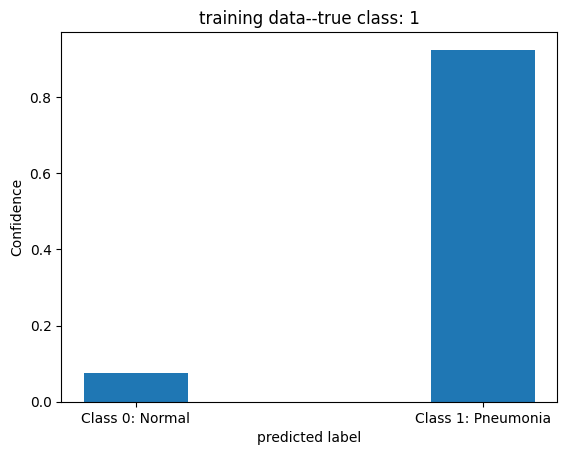

[0.7122883970359908, 0.2877116029640092]


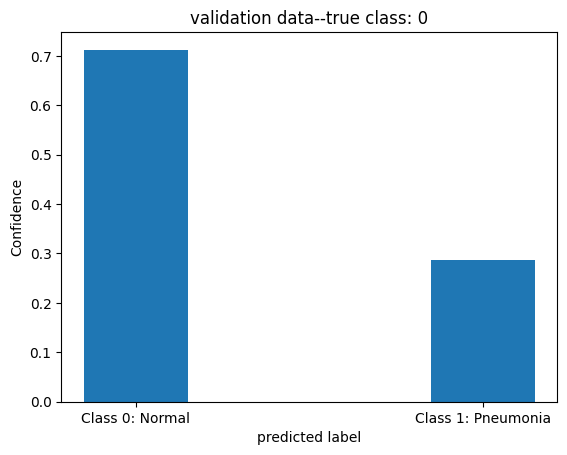

[0.08094346392063945, 0.9190565360793606]


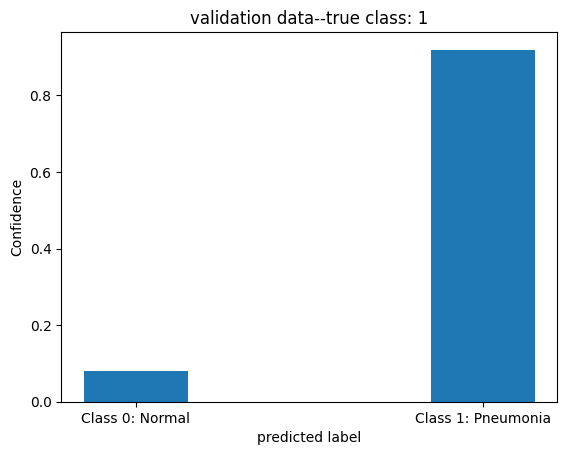

In [ ]:
training_p.compare_logits()

Comparing the output logits

In [ ]:
logits_np_label0 = prepare_attack_dataloader(model_np,train_dataset,out_dataset,0.0)
logits_np_label1 = prepare_attack_dataloader(model_np,train_dataset,out_dataset,1.0)
logits_p_label0 = prepare_attack_dataloader(model_p,train_dataset,out_dataset,0.0)
logits_p_label1 = prepare_attack_dataloader(model_p,train_dataset,out_dataset,1.0)

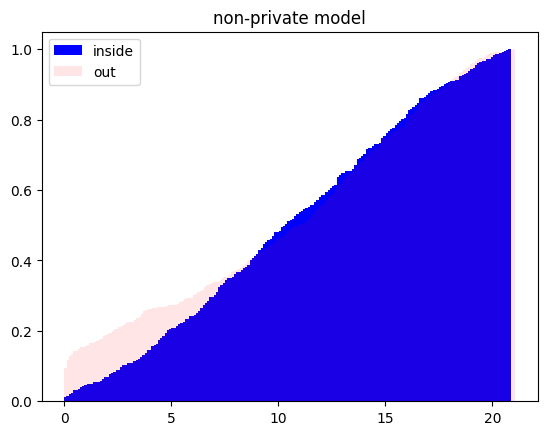

In [ ]:
scatter_in_out_pred(logits_np_label0,label_aux='non-private model')

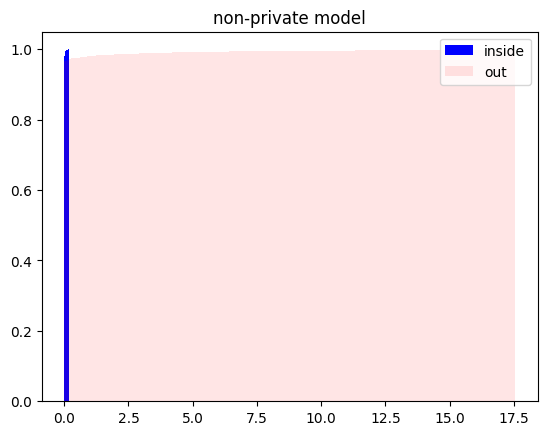

In [ ]:
scatter_in_out_pred(logits_np_label1,label_aux='non-private model')

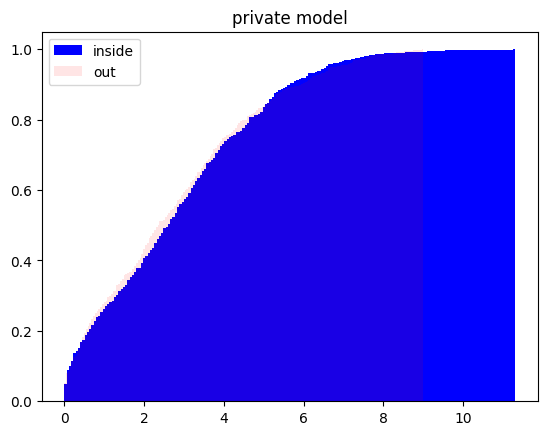

In [ ]:
scatter_in_out_pred(logits_p_label0,label_aux='private model')

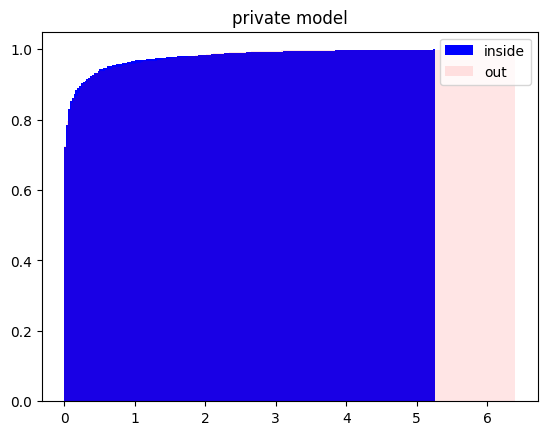

In [ ]:
scatter_in_out_pred(logits_p_label1,label_aux='private model')